In [1]:
import scanpy as sc
import seaborn as sns
import numpy as np
import os
import pandas as pd
import numpy.matlib
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import scipy
import time
directory = '/Users/david/Dropbox/RNASeq/HFD'

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
#load processed mouse VP data
adata = sc.read_h5ad(directory + '/combined.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 34322 × 27809
    obs: 'Sample', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'celltype'
    var: 'n_cells'
    uns: 'Sample_colors', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


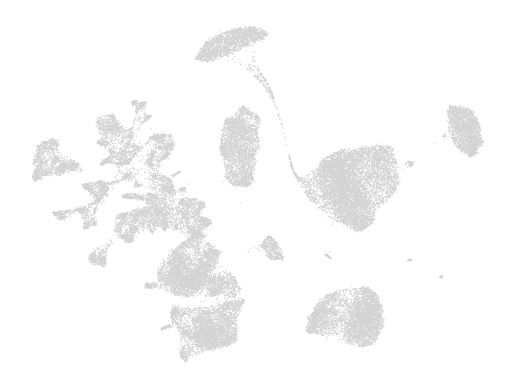

In [7]:
#sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, frameon = False)

In [136]:
gpcolors = {"CL":np.divide((106, 106, 106),256),
            "CS":np.divide((175, 175, 175),256),
            "HL":np.divide((148, 35, 236),256),
            "HS":np.divide((208, 158, 247),256),
           }

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


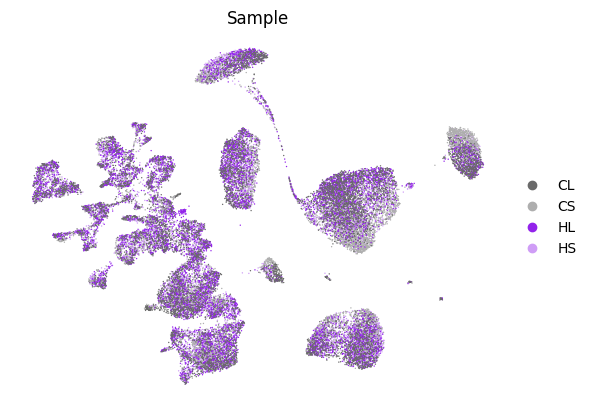

In [10]:
kwargs = {'alpha': 1}
sc.pl.umap(adata, color = ['Sample'], palette = gpcolors, size = 4, frameon = False, **kwargs)

In [264]:
adata_neurons = sc.read_h5ad(directory + '/neurons.h5ad')

In [7]:
#get NT info
allMeta = pd.read_csv('/Users/david/Dropbox/RNASeq/AllenPAL/Data/cell_metadata_with_cluster_annotation.csv')

(sts,ci) = np.unique(allMeta['supertype'].to_numpy(),return_index=True)
nt = allMeta['neurotransmitter'].to_numpy()[ci]
nt[nt!=nt]='None'
stnt = dict(zip(sts,nt))
adata_neurons.obs['neurotransmitter'] = adata_neurons.obs.supertype.map(stnt)

del(allMeta)

/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_50328/3545576851.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  allMeta = pd.read_csv('/Users/david/Dropbox/RNASeq/AllenPAL/Data/cell_metadata_with_cluster_annotation.csv')


In [8]:
#assign cells to brain region according to Allen subclass
vpHy = ['078 SI-MA-ACB Ebf1 Bnc2 Gaba','080 CEA-AAA-BST Six3 Sp9 Gaba','081 ACB-BST-FS D1 Gaba',
                '082 CEA-BST Ebf1 Pdyn Gaba','084 BST-SI-AAA Six3 Slc22a3 Gaba',
         '085 SI-MPO-LPO Lhx8 Gaba','086 MPO-ADP Lhx8 Gaba','088 BST Tac2 Gaba']
vpLGE = ['059 GPe-SI Sox6 Cyp26b1 Gaba','064 STR-PAL Chst9 Gaba']
vpMGE = ['055 STR Lhx8 Gaba','056 Sst Chodl Gaba','057 NDB-SI-MA-STRv Lhx8 Gaba','058 PAL-STR Gaba-Chol']
vpGlut = ['119 SI-MA-LPO-LHA Skor1 Glut','118 ADP-MPO Trp73 Glut']
vpChol = ['Chol']
vsD1 = ['061 STR D1 Gaba']
vsD2 = ['062 STR D2 Gaba']
vsIC = ['060 OT D3 Folh1 Gaba']
vsTshz1 = ['063 STR D1 Sema5a Gaba']

adata_neurons.obs['RegionClass']='Other'
adata_neurons.obs['RegionClass'][adata_neurons.obs['subclass'].isin(vpHy)]='VP GABA HYa'
adata_neurons.obs['RegionClass'][adata_neurons.obs['subclass'].isin(vpLGE)]='VP GABA LGE'
adata_neurons.obs['RegionClass'][adata_neurons.obs['subclass'].isin(vpMGE)]='VP GABA MGE'
adata_neurons.obs['RegionClass'][adata_neurons.obs['subclass'].isin(vpGlut)]='VP Glut'
adata_neurons.obs['RegionClass'][adata_neurons.obs['neurotransmitter'].isin(vpChol)]='VP Chol'
adata_neurons.obs['RegionClass'][adata_neurons.obs['subclass'].isin(vsD1)]='STRv D1'
adata_neurons.obs['RegionClass'][adata_neurons.obs['subclass'].isin(vsD2)]='STRv D2'
adata_neurons.obs['RegionClass'][adata_neurons.obs['subclass'].isin(vsTshz1)]='STRv Tshz1'
adata_neurons.obs['RegionClass'][adata_neurons.obs['subclass'].isin(vsIC)]='STRv IC'

/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_50328/3623879074.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_neurons.obs['RegionClass'][adata_neurons.obs['subclass'].isin(vpHy)]='VP GABA HYa'
/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_50328/3623879074.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_neurons.obs['RegionClass'][adata_neurons.obs['subclass'].isin(vpLGE)]='VP GABA LGE'
/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_50328/3623879074.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

In [9]:
rc=adata_neurons.obs['RegionClass'].to_numpy()
ct=adata.obs['celltype'].to_numpy()
selection = adata.obs['celltype']=='Neurons'
ct[selection]=rc
adata.obs['RegionClass']=ct

In [266]:
#assign cells to brain region according to Allen subclass
vpSubclasses = ['055 STR Lhx8 Gaba','056 Sst Chodl Gaba','058 PAL-STR Gaba-Chol','064 STR-PAL Chst9 Gaba','081 ACB-BST-FS D1 Gaba',
         '057 NDB-SI-MA-STRv Lhx8 Gaba','059 GPe-SI Sox6 Cyp26b1 Gaba','078 SI-MA-ACB Ebf1 Bnc2 Gaba','080 CEA-AAA-BST Six3 Sp9 Gaba',
         '082 CEA-BST Ebf1 Pdyn Gaba','084 BST-SI-AAA Six3 Slc22a3 Gaba',
         '085 SI-MPO-LPO Lhx8 Gaba','086 MPO-ADP Lhx8 Gaba','088 BST Tac2 Gaba',
         '118 ADP-MPO Trp73 Glut','119 SI-MA-LPO-LHA Skor1 Glut']
        

vsSubclasses = ['054 STR Prox1 Lhx6 Gaba','060 OT D3 Folh1 Gaba','061 STR D1 Gaba','062 STR D2 Gaba','063 STR D1 Sema5a Gaba',
               '055 STR Lhx8 Gaba','056 Sst Chodl Gaba','058 PAL-STR Gaba-Chol',
                '064 STR-PAL Chst9 Gaba','078 SI-MA-ACB Ebf1 Bnc2 Gaba','081 ACB-BST-FS D1 Gaba']
adata_neurons.obs['Region']='Other'
adata_neurons.obs['Region'][adata_neurons.obs['subclass'].isin(vpSubclasses)]='VP'
adata_neurons.obs['Region'][adata_neurons.obs['subclass'].isin(vsSubclasses)]='STRv'
adata_neurons.obs['Region'][adata_neurons.obs['subclass'].isin(np.intersect1d(vpSubclasses,vsSubclasses))]='Both'

/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_50328/2116667768.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_neurons.obs['Region'][adata_neurons.obs['subclass'].isin(vpSubclasses)]='VP'
/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_50328/2116667768.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_neurons.obs['Region'][adata_neurons.obs['subclass'].isin(vsSubclasses)]='STRv'
/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_50328/2116667768.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

In [267]:
rc=adata_neurons.obs['Region'].to_numpy()
ct=adata.obs['celltype'].to_numpy()
selection = adata.obs['celltype']=='Neurons'
ct[selection]=rc
adata.obs['Region']=ct

In [10]:
adata.obs['RegionClass']

HS:AAACCCAAGGAGCAAA-1             STRv D1
HS:AAACCCAAGTGCAGGT-1               Other
HS:AAACCCACAAATCGGG-1         VP GABA HYa
HS:AAACCCACAGACATCT-1          Astrocytes
HS:AAACCCACAGCTCGGT-1         VP GABA HYa
                               ...       
CL:TTTGTTGAGCGACCCT-1    Oligodendrocytes
CL:TTTGTTGAGTCACAGG-1         VP GABA HYa
CL:TTTGTTGCACAGCTTA-1           Microglia
CL:TTTGTTGCAGACCCGT-1             STRv IC
CL:TTTGTTGCATTACTCT-1             STRv IC
Name: RegionClass, Length: 34322, dtype: object

In [11]:
grpcolors = {'VP GABA HYa':'#450099',
            'VP GABA LGE':'#B199FF',
            'VP GABA MGE':'#70E000',
            'VP Glut':'#90E0EF',
            'VP Chol':'#4DFFFA',
            'STRv D1':'#005B66',
            'STRv D2':'#FF7800',
            'STRv Tshz1':'#663A2D',
            'STRv IC':'#66580F',
            'Other':(0.8,0.8,0.8,1),
            "Neurons":(0.71, 0.88, 0.54),
            "Oligodendrocytes":(0.86, 0.52, 0.83),
            "Astrocytes":(0.58, 0.73, 0.94),
            "Oligo. precursor cells":(0.97, 0.62, 0.62),
            "Microglia":(0.97, 0.8, 0.55),
            "Fibr./Pericyte/Endothel.":(0.97, 0.93, 0.68),
           }

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


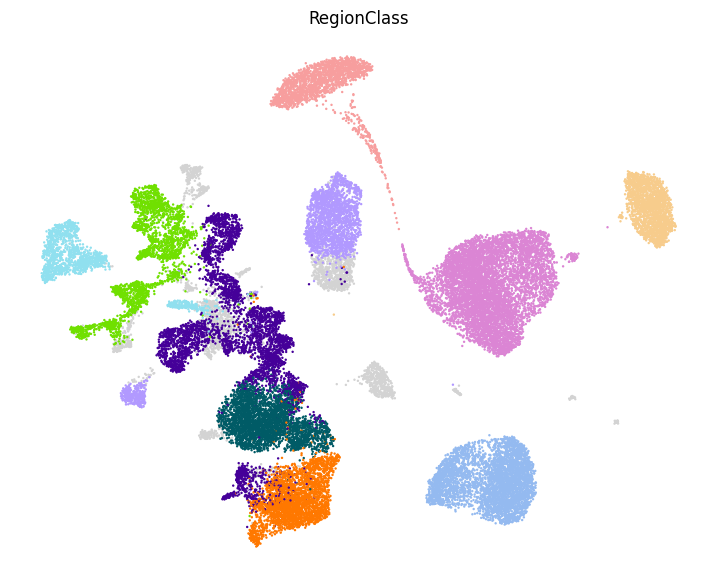

In [25]:
groups = ['Oligodendrocytes','Oligo. precursor cells','Astrocytes','Microglia','VP GABA MGE','VP GABA LGE','VP GABA HYa','VP Glut','STRv D1','STRv D2']
plt.figure(figsize=(9,7))
ax=plt.subplot(1,1,1)
sc.pl.umap(adata, color = ['RegionClass'], size = 12, groups = groups, frameon = False, palette = grpcolors, legend_loc='None', ax=ax, show=False)
plt.savefig(directory + '/Figures/VPHFDgroups.png')

In [26]:
del(adata_neurons)

In [131]:
#prepare for DEG analysis
adata.X = adata.layers['counts'].toarray()
sc.pp.normalize_total(adata, target_sum = 1e4)

In [28]:
#calculate DEGs using all cells, with control short time point as baseline
clusters = ['Oligodendrocytes','Astrocytes','Microglia','Oligo. precursor cells','VP GABA HYa','VP GABA LGE','VP GABA MGE','VP Glut','STRv D1','STRv D2']
goi = ['CL','HS','HL'] #group of interest
contrast = ['CS'] #groups to compare it to
pvals=np.zeros((adata.X.shape[1],len(clusters),len(goi)))
logfc=np.zeros((adata.X.shape[1],len(clusters),len(goi)))
genes=np.sort(adata.var.index)
#ct = np.array(adata.obs['celltype'])
#ctshuff = ct[np.random.choice(len(ct), len(ct), replace=False)]
for c in range(0,len(clusters)):
    selection = (adata.obs['RegionClass'].isin([clusters[c]])) & (adata.obs['Sample'].isin(contrast+goi))
    adataGRP = adata[selection]
    basegrp=adataGRP.obs['Sample'].isin(contrast)
    for s in range(0,len(goi)):
        changegrp=adataGRP.obs['Sample']==goi[s]
        for g in range(0,len(genes)):
            gind=adataGRP.var.index.isin([genes[g]])
            basemean=np.mean(adataGRP[basegrp,gind].X)+(1/np.sum(basegrp|changegrp))
            changemean=np.mean(adataGRP[changegrp,gind].X)+(1/np.sum(changegrp))
            logfc[g,c,s]=np.log2(changemean/basemean)
            if logfc[g,c,s]<0: #if mean of goi is less than contrast
                (stat,pvals[g,c,s])=scipy.stats.mannwhitneyu(adataGRP[changegrp,gind].X.toarray().squeeze(),
                                                             adataGRP[basegrp,gind].X.toarray().squeeze(), alternative='less') #corrects for ties
            else: #if mean of goi is greater than contrast
                (stat,pvals[g,c,s])=scipy.stats.mannwhitneyu(adataGRP[changegrp,gind].X.toarray().squeeze(),
                                                             adataGRP[basegrp,gind].X.toarray().squeeze(), alternative='greater') #corrects for ties

In [132]:
#calculate DEGs using all cells, with control short time point as baseline
clusters = ['Oligodendrocytes','Astrocytes','Microglia','Oligo. precursor cells','VP GABA HYa','VP GABA LGE','VP GABA MGE','VP Glut','STRv D1','STRv D2']
goi = ['CL','HS','HL'] #group of interest
contrast = ['CS'] #groups to compare it to
genes = np.sort(adata.var.index)
geneOrder = np.argsort(adata.var.index)
pvals=np.zeros((adata.X.shape[1],len(clusters),len(goi)))
logfc=np.zeros((adata.X.shape[1],len(clusters),len(goi)))
for c in range(0,len(clusters)):
    selection = (adata.obs['RegionClass'].isin([clusters[c]])) & (adata.obs['Sample'].isin(contrast+goi))
    adataGRP = adata[selection,geneOrder]
    basegrp=adataGRP.obs['Sample'].isin(contrast)
    baseArray = adataGRP[basegrp].X.toarray()
    tic = time.perf_counter()
    for s in range(0,len(goi)):
        changegrp=adataGRP.obs['Sample']==goi[s]
        changeArray = adataGRP[changegrp].X.toarray()                    
        for g in range(0,len(genes)):
            change = changeArray[:,g]
            base = baseArray[:,g]            
            basemean=np.mean(base)+(1/len(adata)) #add a very small value so that it's not undefined with no counts
            changemean=np.mean(change)+(1/len(adata))
            logfc[g,c,s]=np.log2(changemean/basemean)
            (stat,pvals[g,c,s])=scipy.stats.mannwhitneyu(change,base,alternative='two-sided') #corrects for ties
    toc = time.perf_counter()
    print(f"Completed cluster {c} in {toc - tic:0.4f} seconds")

Completed cluster 0 in 73.3341 seconds
Completed cluster 1 in 55.2855 seconds
Completed cluster 2 in 47.9547 seconds
Completed cluster 3 in 46.4197 seconds
Completed cluster 4 in 62.5609 seconds
Completed cluster 5 in 49.3267 seconds
Completed cluster 6 in 50.0410 seconds
Completed cluster 7 in 53.9390 seconds
Completed cluster 8 in 57.2506 seconds
Completed cluster 9 in 53.4068 seconds


In [334]:
with open(directory+'/DEG_pvals.npy', 'wb') as f:
    np.save(f, pvals)
with open(directory+'/DEG_logfc.npy', 'wb') as f:
    np.save(f, logfc)

In [64]:
with open(directory+'/DEG_pvals.npy', 'rb') as f:
    pvals = np.load(f)
with open(directory+'/DEG_logfc.npy', 'rb') as f:
    logfc = np.load(f)

In [133]:
#pvalc = scipy.stats.false_discovery_control(pvals, axis=0, method='by') #benjamini-yekutieli
pvalc = pvals*len(genes) #bonferroni
pvalc[pvalc>1]=1

In [134]:
len(genes)

27809

In [154]:
#calculate DEGs using all cells, late time point
clusters = ['Oligodendrocytes','Astrocytes','Microglia','Oligo. precursor cells','VP GABA HYa','VP GABA LGE','VP GABA MGE','VP Glut','STRv D1','STRv D2']
goi = ['HL'] #group of interest
contrast = ['CL'] #groups to compare it to
genes = np.sort(adata.var.index)
geneOrder = np.argsort(adata.var.index)
pvalsL=np.zeros((adata.X.shape[1],len(clusters)))
logfcL=np.zeros((adata.X.shape[1],len(clusters)))
for c in range(0,len(clusters)):
    selection = (adata.obs['RegionClass'].isin([clusters[c]])) & (adata.obs['Sample'].isin(contrast+goi))
    adataGRP = adata[selection,geneOrder]
    basegrp=adataGRP.obs['Sample'].isin(contrast)
    baseArray = adataGRP[basegrp].X.toarray()
    for s in range(0,len(goi)):
        changegrp=adataGRP.obs['Sample']==goi[s]
        changeArray = adataGRP[changegrp].X.toarray()            
        tic = time.perf_counter()
        for g in range(0,len(genes)):
            change = changeArray[:,g]
            base = baseArray[:,g]            
            basemean=np.mean(base)+(1/len(adata)) #add a very small value so that it's not undefined with no counts
            changemean=np.mean(change)+(1/len(adata))
            logfcL[g,c]=np.log2(changemean/basemean)
            (stat,pvalsL[g,c])=scipy.stats.mannwhitneyu(change,base,alternative='two-sided') #corrects for ties

            #if logfcL[g,c]<0: #if mean of goi is less than contrast
            #    (stat,pvalsL[g,c])=scipy.stats.mannwhitneyu(change,base,alternative='less')
            #else: #if mean of goi is greater than contrast
            #    (stat,pvalsL[g,c])=scipy.stats.mannwhitneyu(change,base,alternative='greater')

    
    toc = time.perf_counter()
    print(f"Completed cluster {c} in {toc - tic:0.4f} seconds")

Completed cluster 0 in 69.1283 seconds
Completed cluster 1 in 54.2018 seconds
Completed cluster 2 in 43.4690 seconds
Completed cluster 3 in 44.3495 seconds
Completed cluster 4 in 57.6931 seconds
Completed cluster 5 in 47.0795 seconds
Completed cluster 6 in 48.7879 seconds
Completed cluster 7 in 44.1439 seconds
Completed cluster 8 in 51.8790 seconds
Completed cluster 9 in 49.6100 seconds


In [179]:
with open(directory+'/DEG_pvalsL.npy', 'wb') as f:
    np.save(f, pvalsL)
with open(directory+'/DEG_logfcL.npy', 'wb') as f:
    np.save(f, logfcL)

In [78]:
with open(directory+'/DEG_pvalsL.npy', 'rb') as f:
    pvalsL = np.load(f)
with open(directory+'/DEG_logfcL.npy', 'rb') as f:
    logfcL = np.load(f)

In [62]:
DEGcolors = {"Neurons":(0.71, 0.88, 0.54),
            "Oligodendrocytes":(0.86, 0.52, 0.83),
            "Astrocytes":(0.58, 0.73, 0.94),
            "Oligo. precursor cells":(0.97, 0.62, 0.62),
            "Microglia":(0.97, 0.8, 0.55),
            "Fibr./Murine/Endothel.":(0.97, 0.93, 0.68),
            'VP GABA HYa':'#450099',
            'VP GABA LGE':'#B199FF',
            'VP GABA MGE':'#70E000',
            'VP Glut':'#90E0EF',
            'VP Chol':'#4DFFFA',
            'STRv D1':'#005B66',
            'STRv D2':'#FF7800',
            'STRv Tshz1':'#663A2D',
            'STRv IC':'#66580F',
            'Other':(0.8,0.8,0.8,1)             
           }

In [155]:
#pvalc = scipy.stats.false_discovery_control(pvals, axis=0, method='by') #benjamini-yekutieli
pvalcL = pvalsL*len(genes) #bonferroni
pvalcL[pvalcL>1]=1

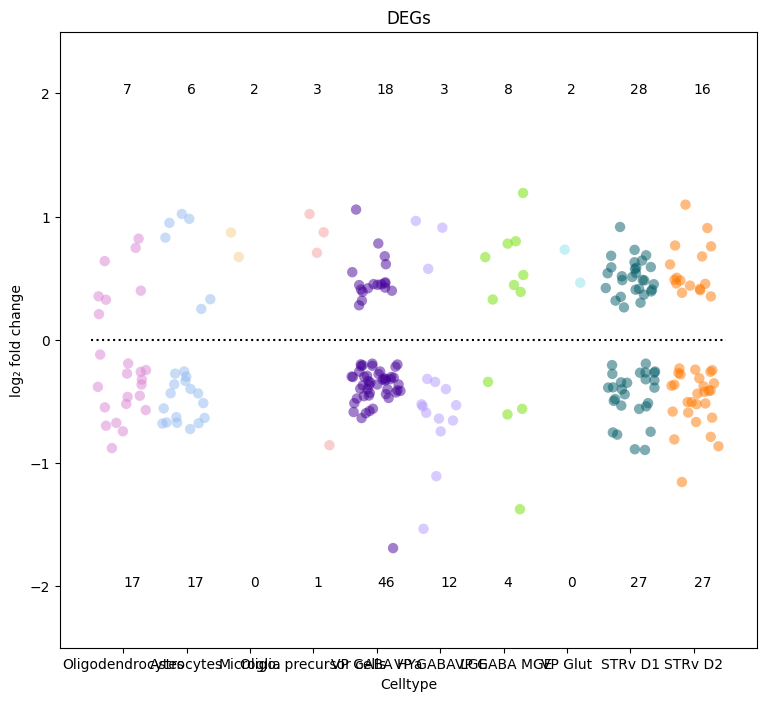

In [178]:
#plot 
plt.figure(figsize = (9,8))
deginfo = pd.DataFrame(columns=['Gene','Celltype','TP','LFC','PVC'])
for x in range(0,len(clusters)):
    #selection = (pvalcL[:,x]<0.05) & (np.abs(logfcL[:,x])>0.322)
    #selection = selection & (pvalc[:,x,2]<0.05) & (np.abs(logfc[:,x,2])>0.322)
    selection = (pvalcL[:,x]<0.05) & (pvalc[:,x,2]<0.05) & (np.sign(logfc[:,x,2])==np.sign(logfcL[:,x]))
    #selection = (pvalcL[:,x]<0.05) & (pvalc[:,x,1]<0.05) & (np.sign(logfc[:,x,1])==np.sign(logfcL[:,x]))
    
    add = {'Gene':genes[selection],'Celltype':[clusters[x]]*np.sum(selection),'LFC':logfcL[selection,x],'PVC':pvalcL[selection,x]}
    deginfo = pd.concat([deginfo,pd.DataFrame(add)])

#sns.violinplot(deginfo, x='Celltype', y='LFC', hue='TP',split = 'true', inner='quartile', bw_adjust=0.5)
sns.stripplot(deginfo, x='Celltype', y='LFC', hue='Celltype', palette=DEGcolors, legend=False, jitter=0.4, alpha=0.5, size=7.5)
plt.ylim((-2.5,2.5))
plt.title('DEGs')
#plt.ylabel('-log\u2081\u2080 p-value')
plt.ylabel('log\u2082 fold change')
plt.plot((-0.5,len(clusters)-0.5),(0,0),':',color='black')
for x in range(0,len(clusters)):
    selection = (pvalcL[:,x]<0.05) & (pvalc[:,x,2]<0.05) & (np.sign(logfc[:,x,2])==np.sign(logfcL[:,x]))
    plt.text(x = x, y = -2, s = np.sum(selection & (logfcL[:,x]<0)),#np.sum((pvalcL[:,x]<0.05) & (logfcL[:,x]<-0.322)),
        fontsize = 10)
    plt.text(x = x, y = 2, s = np.sum(selection & (logfcL[:,x]>0)),
        fontsize = 10)

plt.savefig(directory + '/Figures/allDEGs.svg')

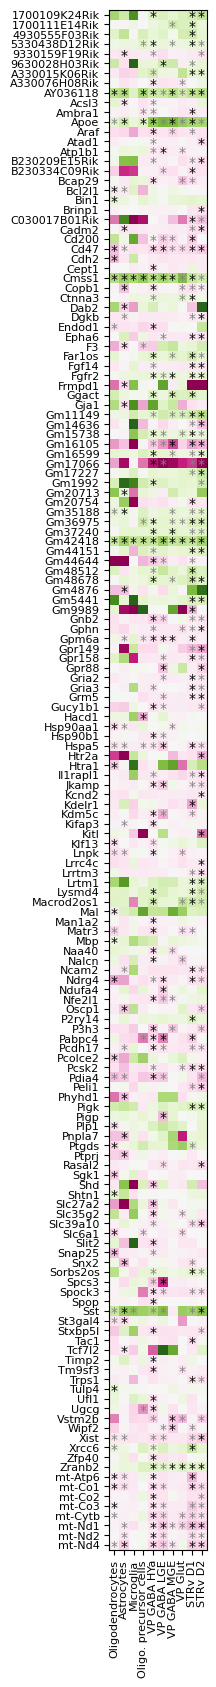

In [293]:
#plot all DEGs for all cell types
clusters = ['Oligodendrocytes','Astrocytes','Microglia','Oligo. precursor cells','VP GABA HYa','VP GABA LGE','VP GABA MGE','VP Glut','STRv D1','STRv D2']
wgs = np.unique(deginfo.Gene)
wgsSel = np.isin(genes,wgs)
wglfc = logfcL[wgsSel,:]

#p-value corrected for number of genes in this list (DEGs)
wgpv = len(allpathwaygenes)*np.max(np.stack((pvalsL[wgsSel,:],pvals[wgsSel,:,2]),axis=2),axis=2)

#p-value corrected for total number of genes
wgpva = len(genes)*np.max(np.stack((pvalsL[wgsSel,:],pvals[wgsSel,:,2]),axis=2),axis=2)

#sorting
wgorder = np.argsort(wgs)
wglfc = wglfc[wgorder]
wgsort = wgs[wgorder]
wgpvsort = wgpv[wgorder]
wgpvasort = wgpva[wgorder]

plt.figure(figsize = (2,20))
plt.imshow(wglfc,cmap='PiYG', vmin=-2, vmax=2)
plt.yticks(range(0,len(wgs)),labels=wgsort, size=8)
plt.xticks(range(0,len(clusters)),labels=clusters, rotation=90, size=8)
#plt.colorbar(label='log\u2082 fold change')
for g in range(0,len(wgs)):
    for c in range(0,len(clusters)):
        if wgpvasort[g,c]<0.05:
            plt.text(y=g+0.6,x=c-0.4,s='*',size=10,color='k')
        else:
            if wgpvsort[g,c]<0.05:
                plt.text(y=g+0.6,x=c-0.4,s='*',size=10,color=(0.5,0.5,0.5))
                
plt.savefig(directory + '/Figures/DEGsAll.svg')

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


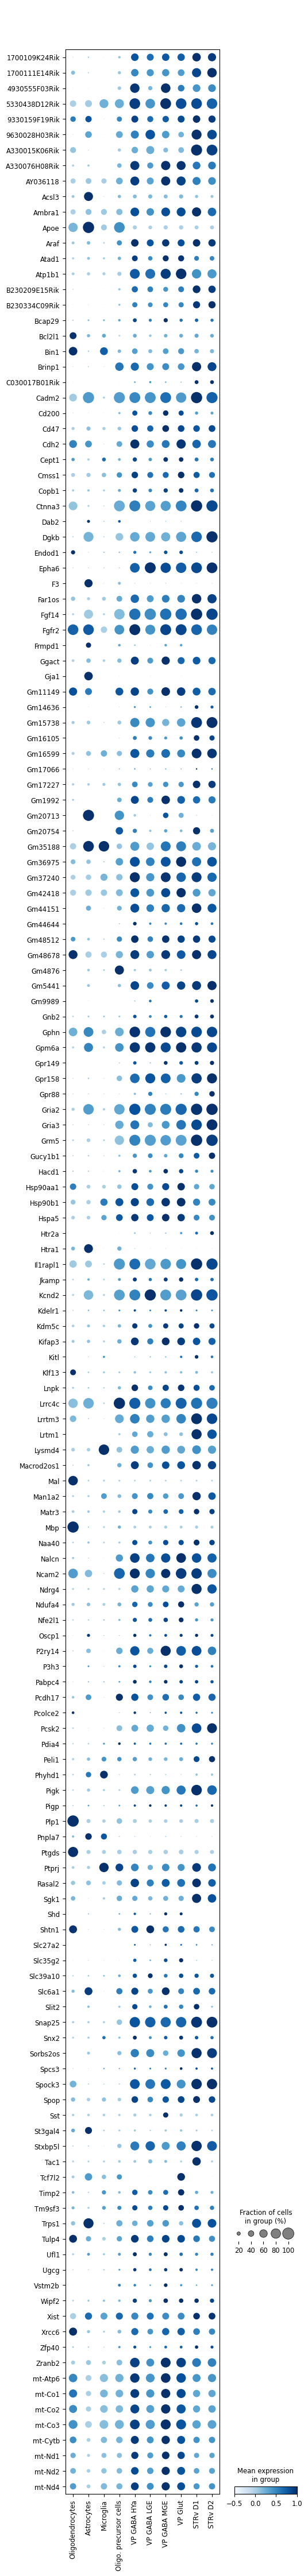

In [295]:
dp = sc.pl.dotplot(adata[adata.obs['RegionClass'].isin(clusters)], wgsort, layer='counts',groupby='RegionClass', categories_order=clusters,
                   standard_scale='var', vmin=-0.5, vmax=1,dendrogram=False, return_fig=True, swap_axes=True) 
dp.style(dot_edge_color=None, dot_edge_lw=0.5, cmap='Blues', x_padding=0.5, y_padding=0.5)

#dp.add_totals(sort=None, color='black').style(dot_edge_color=None, dot_edge_lw=0.5, cmap='Blues', x_padding=0.5, y_padding=0.5)
dp.savefig(directory + '/Figures/DEGsAllDot.svg')

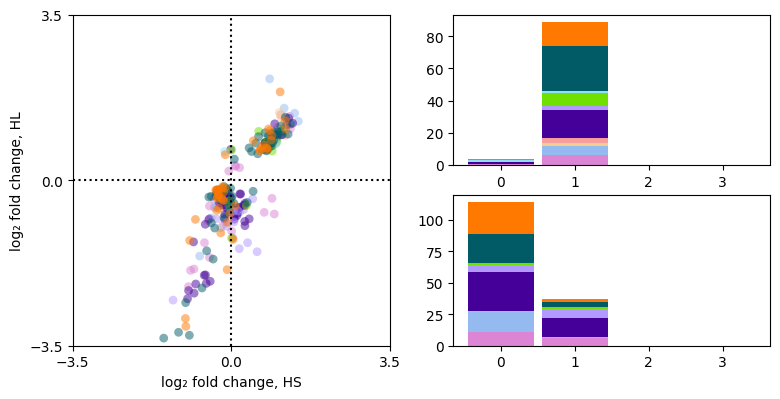

In [158]:
plt.figure(figsize = (9,4.3))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,4)
amplist=[]
HLall=[]
HSall=[]
slCorr=[]
bottom1 = np.zeros(4)
bottom2 = np.zeros(4)
up = np.zeros(4)
down = np.zeros(4)
width = 0.9
for cl in range(0,len(clusters)):
    #selection = (pvalcL[:,cl]<0.05) & (np.abs(logfcL[:,cl])>0.808)
    selection = (pvalcL[:,cl]<0.05) & (pvalc[:,cl,2]<0.05) & (np.sign(logfc[:,cl,2])==np.sign(logfcL[:,cl])) #& (np.abs(logfcL[:,cl])>0.322) & (np.abs(logfc[:,cl,2])>0.322)
    #selection = (pvalcL[:,cl]<0.05) & (pvalc[:,cl,1]<0.05) & (np.sign(logfc[:,cl,1])==np.sign(logfcL[:,x]))
    
    geneSub = genes[selection]
    lfcsSub = logfc[selection,cl,1]
    lfclSub = logfc[selection,cl,2]

    slCorr.append(scipy.stats.pearsonr(lfcsSub,lfclSub))

    #how many in each quadrant
    #up[0]=np.sum((lfclSub>0) & (lfcsSub<0) & (lfclSub<-lfcsSub))
    #up[1]=np.sum((lfclSub>0) & (lfcsSub<=0) & (lfclSub>-lfcsSub))
    #up[2]=np.sum((lfclSub>0) & (lfcsSub>0) & (lfclSub>lfcsSub))
    #up[3]=np.sum((lfclSub>0) & (lfcsSub>0) & (lfclSub<lfcsSub))
    #down[0]=np.sum((lfclSub<0) & (lfcsSub<0) & (lfclSub>lfcsSub))
    #down[1]=np.sum((lfclSub<0) & (lfcsSub<=0) & (lfclSub<lfcsSub))
    #down[2]=np.sum((lfclSub<0) & (lfcsSub>0) & (-lfclSub>lfcsSub))
    #down[3]=np.sum((lfclSub<0) & (lfcsSub>0) & (-lfclSub<lfcsSub))
    up[0]=np.sum((lfclSub>0) & (lfcsSub<=0))
    up[1]=np.sum((lfclSub>0) & (lfcsSub>0))
    down[0]=np.sum((lfclSub<0) & (lfcsSub<0))
    down[1]=np.sum((lfclSub<0) & (lfcsSub>=0))
    ax2.bar(np.arange(0,4), up, width, label=clusters[cl], bottom=bottom1, color=DEGcolors[clusters[cl]])
    bottom1 += up
    ax3.bar(np.arange(0,4), down, width, label=clusters[cl], bottom=bottom2, color=DEGcolors[clusters[cl]])
    bottom2 += down
    
    ax1.scatter(lfcsSub,lfclSub,s=40, alpha=0.5, edgecolor='None', facecolor=DEGcolors[clusters[cl]])

    #calculate line
    #lr=LinearRegression(fit_intercept=False).fit(lfcsSub.reshape(-1, 1),lfclSub)
    #yvals=lr.predict(np.array((-3.5,3.5)).reshape(-1, 1))
    #plt.plot((-3.5,3.5),yvals,color=DEGcolors[clusters[cl]])

    amplist=np.concatenate((amplist,genes[selection & ((np.sign(logfcL[:,cl])*logfc[:,cl,2])>(np.sign(logfcL[:,cl])*logfc[:,cl,1]))]))
    HLall=np.concatenate((HLall,lfclSub))
    HSall=np.concatenate((HSall,lfcsSub))
    

    #for i, txt in enumerate(geneSub):
    #    if np.abs(lfclSub[i])>1.5:
    #        ax1.annotate(txt, (lfcsSub[i]+1.5, lfclSub[i]), size=4)
plt.subplot(1,2,1)
plt.xticks((-3.5,0,3.5))
plt.yticks((-3.5,0,3.5))
plt.plot((-3.5,3.5),(0,0),':',color='black')
#plt.plot((-3.5,3.5),(1.5,1.5),':',color='black')
#plt.plot((-3.5,3.5),(-1.5,-1.5),':',color='black')
plt.plot((0,0),(-3.5,3.5),':',color='black')
#plt.plot((-3.5,3.5),(-3.5,3.5),':',color='black')
plt.xlabel('log\u2082 fold change, HS')
plt.ylabel('log\u2082 fold change, HL')
#plt.title(clusters[cl])
plt.xlim((-3.5,3.5))
plt.ylim((-3.5,3.5))
#calculate line
#lr=LinearRegression(fit_intercept=False).fit(HSall.reshape(-1, 1),HLall)
#yvals=lr.predict(np.array((-3.5,3.5)).reshape(-1, 1))
#plt.plot((-3.5,3.5),yvals,color='black')
slCorrAll = scipy.stats.pearsonr(HSall,HLall)
x2up = scipy.stats.chisquare(bottom1[0:2])
x2down = scipy.stats.chisquare(bottom2[0:2])

plt.savefig(directory + '/Figures/HSHLDEGs.svg')

In [159]:
slCorrAll

PearsonRResult(statistic=0.8684156915568384, pvalue=1.1022200976039738e-75)

In [161]:
x2up

Power_divergenceResult(statistic=77.68817204301075, pvalue=1.2066173946448302e-18)

In [162]:
x2down

Power_divergenceResult(statistic=39.264900662251655, pvalue=3.7003366324233617e-10)

In [163]:
#decode HL or CL for each cluster
clusters = ['Oligodendrocytes','Astrocytes','Microglia','Oligo. precursor cells','VP GABA HYa','VP GABA LGE','VP GABA MGE','VP Glut','STRv D1','STRv D2']
goi = ['HL','CL'] #group of interest
selection = (adata.obs['RegionClass'].isin(clusters)) & (adata.obs['Sample'].isin(goi))
geneSelection=adata.var.index.isin(deginfo.Gene)
adataSub = adata[selection,geneSelection]
adataSub.X = adataSub.layers['counts'].toarray()
sc.pp.normalize_total(adataSub, target_sum = 1e4)
totals = []
totalsCL = []
totalsHL = []
for c in range(0,len(clusters)):
    totals.append(np.sum(adataSub.obs['RegionClass'].isin([clusters[c]])))
    totalsHL.append(np.sum(adataSub.obs['RegionClass'].isin([clusters[c]]) & adataSub.obs['Sample'].isin(['HL'])))
    totalsCL.append(np.sum(adataSub.obs['RegionClass'].isin([clusters[c]]) & adataSub.obs['Sample'].isin(['CL'])))


/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [165]:
folds = 5
ss = np.min(totalsHL+totalsCL)
ss = int(folds*np.floor(ss/folds))
ytrain = np.concatenate((np.ones(int(ss*4/5)),np.zeros(int(ss*4/5))))
yshtrain = np.matlib.repmat(np.array((1,0)),1,int(ss*4/5)).squeeze()
ytest = np.concatenate((np.ones(int(ss*1/5)),np.zeros(int(ss*1/5))))
yshtest = np.matlib.repmat(np.array((1,0)),1,int(ss*1/5)).squeeze()

In [166]:
ss

330

In [167]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC

In [168]:
reps = 1000
accuracy = np.zeros((reps,len(clusters)))
accuracySh = np.zeros((reps,len(clusters)))
for c in range(0,len(clusters)):
    print(('cluster ' + str(c)))
    selection = adataSub.obs['RegionClass'].isin([clusters[c]])
    adataGRP = adataSub[selection]   
    HLlist = np.flatnonzero(adataGRP.obs['Sample']=='HL')
    CLlist = np.flatnonzero(adataGRP.obs['Sample']=='CL')
    for x in range(0,reps):
        if np.remainder(x,50)==0:
            print(('rep ' + str(x)))
        HLchoices = HLlist[np.random.choice(len(HLlist), size=ss, replace=True)]
        CLchoices = CLlist[np.random.choice(len(CLlist), size=ss, replace=True)]
        prediction = []
        truth = []
        for f in range(0,folds):
            #print(('fold ' + str(f)))
            fsel = range(int(f*ss/folds),int((f+1)*ss/folds))
            test = np.concatenate((HLchoices[fsel],CLchoices[fsel]))
            train = np.concatenate((HLchoices[~np.isin(range(0,ss),fsel)],CLchoices[~np.isin(range(0,ss),fsel)]))
            #mdl = SVC(C=1, kernel='linear') #'rbf' is the fancy one
            mdl = RandomForestClassifier(n_estimators=30, bootstrap=True)
            mdl.fit(adataGRP[train].X, ytrain)
            prediction.append(mdl.predict(adataGRP[test].X))
            truth.append(ytest)
        prediction = [item for sublist in prediction for item in sublist]
        truth = [item for sublist in truth for item in sublist]
        accuracy[x,c]=np.sum(np.equal(prediction,truth))/(ss*2)
        #now for shuffle
        prediction = []
        truth = []        
        for f in range(0,folds):
            fsel = range(int(f*ss/folds),int((f+1)*ss/folds))
            test = np.concatenate((HLchoices[fsel],CLchoices[fsel]))
            train = np.concatenate((HLchoices[~np.isin(range(0,ss),fsel)],CLchoices[~np.isin(range(0,ss),fsel)]))
            #mdl = SVC(C=1, kernel='linear') #'rbf' is the fancy one
            mdl = RandomForestClassifier(n_estimators=30, bootstrap=True)
            mdl.fit(adataGRP[train].X, yshtrain)
            prediction.append(mdl.predict(adataGRP[test].X))
            truth.append(yshtest)
        prediction = [item for sublist in prediction for item in sublist]
        truth = [item for sublist in truth for item in sublist]
        accuracySh[x,c]=np.sum(np.equal(prediction,truth))/(ss*2)        

cluster 0
rep 0
rep 50
rep 100
rep 150
rep 200
rep 250
rep 300
rep 350
rep 400
rep 450
rep 500
rep 550
rep 600
rep 650
rep 700
rep 750
rep 800
rep 850
rep 900
rep 950
cluster 1
rep 0
rep 50
rep 100
rep 150
rep 200
rep 250
rep 300
rep 350
rep 400
rep 450
rep 500
rep 550
rep 600
rep 650
rep 700
rep 750
rep 800
rep 850
rep 900
rep 950
cluster 2
rep 0
rep 50
rep 100
rep 150
rep 200
rep 250
rep 300
rep 350
rep 400
rep 450
rep 500
rep 550
rep 600
rep 650
rep 700
rep 750
rep 800
rep 850
rep 900
rep 950
cluster 3
rep 0
rep 50
rep 100
rep 150
rep 200
rep 250
rep 300
rep 350
rep 400
rep 450
rep 500
rep 550
rep 600
rep 650
rep 700
rep 750
rep 800
rep 850
rep 900
rep 950
cluster 4
rep 0
rep 50
rep 100
rep 150
rep 200
rep 250
rep 300
rep 350
rep 400
rep 450
rep 500
rep 550
rep 600
rep 650
rep 700
rep 750
rep 800
rep 850
rep 900
rep 950
cluster 5
rep 0
rep 50
rep 100
rep 150
rep 200
rep 250
rep 300
rep 350
rep 400
rep 450
rep 500
rep 550
rep 600
rep 650
rep 700
rep 750
rep 800
rep 850
rep 900
rep 95

In [170]:
np.mean(accuracy,axis=0)

array([0.74001818, 0.78380455, 0.80243182, 0.82397576, 0.7631803 ,
       0.81650455, 0.80052879, 0.85108333, 0.78424091, 0.79864242])

In [171]:
accuracyAll=np.concatenate((np.reshape(accuracy,reps*len(clusters),order='F'),
                            np.reshape(accuracySh,reps*len(clusters),order='F')))
clusterAll=[]
for x in range(0,2):
    for c in range(0,len(clusters)):
        clusterAll=np.concatenate((clusterAll,[clusters[c]]*reps))
shuffleAll=np.concatenate((['True']*reps*len(clusters),['Shuff']*reps*len(clusters)))

In [172]:
decoding = pd.DataFrame({'Accuracy':accuracyAll,'Shuffle':shuffleAll,'Cluster':clusterAll})

In [173]:
accdiff = accuracy-accuracySh
accp = (np.sum(accdiff<=0,axis=0)+1)/(reps+1)
comp = np.zeros((len(clusters),len(clusters)))
for c1 in range(0,len(clusters)):
    for c2 in range(0,len(clusters)):
        upper=accuracy[:,c1]
        lower=accuracy[:,c2]
        alldiff=np.subtract.outer(upper,lower)
        comp[c1,c2]=(np.sum(alldiff<=0,axis=None)+1)/(np.power(reps,2)+1)
comp

array([[5.11571488e-01, 9.57521042e-01, 9.93126007e-01, 9.99632000e-01,
        8.18485182e-01, 9.99094001e-01, 9.91602008e-01, 9.99995000e-01,
        9.62692037e-01, 9.91584008e-01],
       [4.80889519e-02, 5.12959487e-01, 7.89985210e-01, 9.59785040e-01,
        2.12577787e-01, 9.24141076e-01, 7.67346233e-01, 9.98680001e-01,
        5.22132478e-01, 7.47520252e-01],
       [8.06399194e-03, 2.28006772e-01, 5.13285487e-01, 8.34941165e-01,
        5.98209402e-02, 7.37562262e-01, 4.79491521e-01, 9.88345012e-01,
        2.28804771e-01, 4.46913553e-01],
       [4.42999557e-04, 4.61769538e-02, 1.82110818e-01, 5.14146486e-01,
        5.71399429e-03, 3.78455622e-01, 1.60148840e-01, 9.06375094e-01,
        4.14849585e-02, 1.33544866e-01],
       [1.96995803e-01, 8.04415196e-01, 9.47147053e-01, 9.95245005e-01,
        5.12225488e-01, 9.88834011e-01, 9.38950061e-01, 9.99950000e-01,
        8.13789186e-01, 9.33613066e-01],
       [1.11399889e-03, 8.56729143e-02, 2.85177715e-01, 6.46845353e-01,
   

In [174]:
#which clusters are greater than shuffle, bonferroni corrected (5 comparisons)
(accp*len(clusters))<0.05

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [175]:
((np.power(len(clusters),2)-len(clusters))/2)

45.0

In [176]:
#which clusters (row) are greater than which clusters (column), bonferroni corrected
(comp*((np.power(len(clusters),2)-len(clusters))/2))<0.05

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [ True, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [ True, False, False, False,  True, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])

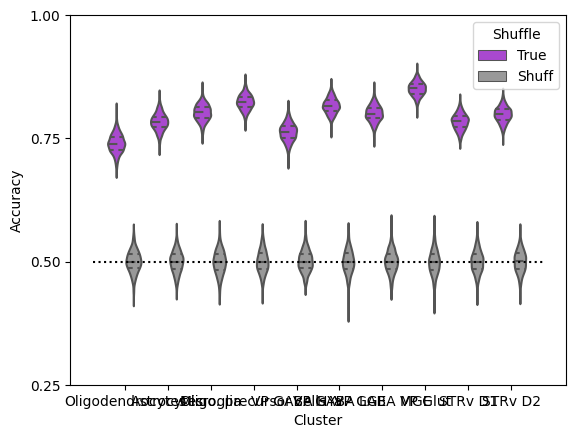

In [177]:
sns.violinplot(decoding,x='Cluster',y='Accuracy',hue='Shuffle',split=False,inner='quart',palette={'True':[.7,0.2,0.9],'Shuff':[0.6,0.6,0.6]})
plt.plot([-0.75,len(clusters)-0.25],[0.5,0.5],':',color='black')
plt.ylim((0.25,1))
plt.yticks(ticks=[0.25,0.5,0.75,1])
plt.savefig(directory + '/Figures/cellsDecoding.svg')

In [212]:
decoding.to_hdf(directory+'/cellDecoding.hf',key='decoding')

In [299]:
deginfo

,Gene,Celltype,TP,LFC,PVC
0,AY036118,Oligodendrocytes,NaN,0.745773,0.000006
1,Adipor2,Oligodendrocytes,NaN,-0.292820,0.000597
2,Bcl2l1,Oligodendrocytes,NaN,-0.260806,0.000568
3,Bin1,Oligodendrocytes,NaN,0.324507,0.003117
4,Cd47,Oligodendrocytes,NaN,-0.674517,0.000014
...,...,...,...,...,...
42,Sst,STRv D2,NaN,1.091422,0.004893
43,Xist,STRv D2,NaN,-0.591692,0.002486
44,Zranb2,STRv D2,NaN,0.411674,0.005024
45,mt-Nd1,STRv D2,NaN,-0.631932,0.000550


In [182]:
deglist = np.unique(deginfo.Gene).tolist()

In [183]:
degmatrix = np.zeros((len(deglist),len(clusters)))
for g in range(0,len(deglist)):
    for c in range(0,len(clusters)):
        sel = (deginfo.Gene==deglist[g]) & (deginfo.Celltype==clusters[c])
        if np.sum(sel)>0:
            degmatrix[g,c]=np.sign(deginfo.LFC[sel])

In [184]:
degmatrix = pd.DataFrame(degmatrix,columns=clusters,index=deglist).astype('int')

In [185]:
degmatrix.to_csv(directory + '/HFDDEGlist.csv', index=True)

In [188]:
nd = len(np.unique(deginfo.Gene).tolist())
ng = len(genes)
nd

158

In [187]:
pvs=[]
nks=[]
for shuff in range(0,1000):
    degshuff = genes[np.random.choice(ng, nd, replace=False)]
    kwargs = {'sources':['KEGG']}
    processes = sc.queries.enrich(degshuff.tolist(), org="mmusculus", gprofiler_kwargs=kwargs)
    pvs.append(np.min(processes.p_value))
    nks.append(len(processes))

In [189]:
#get the p-value cutoff for FDR of 0.01 (better than 99% of shuffles)
pvmin = np.sort(np.array(pvs)[np.array(pvs)==np.array(pvs)])[9] 
pvmin

0.0024416940098953483

In [205]:
kwargs = {'sources':['KEGG']}
processes = sc.queries.enrich(deglist, org="mmusculus", gprofiler_kwargs=kwargs)
processes = processes[processes.p_value<0.00245]
processes

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,KEGG,KEGG:05022,Pathways of neurodegeneration - multiple diseases,0.000028,True,Pathways of neurodegeneration - multiple diseases,470,71,16,9330,0.225352,0.034043,query_1,[KEGG:00000]
1,KEGG,KEGG:05016,Huntington disease,0.000029,True,Huntington disease,301,71,13,9330,0.183099,0.043189,query_1,[KEGG:00000]
2,KEGG,KEGG:05014,Amyotrophic lateral sclerosis,0.000044,True,Amyotrophic lateral sclerosis,367,71,14,9330,0.197183,0.038147,query_1,[KEGG:00000]
3,KEGG,KEGG:05012,Parkinson disease,0.000049,True,Parkinson disease,263,71,12,9330,0.169014,0.045627,query_1,[KEGG:00000]
4,KEGG,KEGG:00190,Oxidative phosphorylation,0.000059,True,Oxidative phosphorylation,134,71,9,9330,0.126761,0.067164,query_1,[KEGG:00000]
5,KEGG,KEGG:05208,Chemical carcinogenesis - reactive oxygen species,0.000067,True,Chemical carcinogenesis - reactive oxygen species,222,71,11,9330,0.154930,0.049550,query_1,[KEGG:00000]
6,KEGG,KEGG:05010,Alzheimer disease,0.000069,True,Alzheimer disease,381,71,14,9330,0.197183,0.036745,query_1,[KEGG:00000]
7,KEGG,KEGG:05020,Prion disease,0.000393,True,Prion disease,266,71,11,9330,0.154930,0.041353,query_1,[KEGG:00000]
8,KEGG,KEGG:04714,Thermogenesis,0.000690,True,Thermogenesis,229,71,10,9330,0.140845,0.043668,query_1,[KEGG:00000]
9,KEGG,KEGG:04723,Retrograde endocannabinoid signaling,0.001227,True,Retrograde endocannabinoid signaling,147,71,8,9330,0.112676,0.054422,query_1,[KEGG:00000]


In [206]:
processes.to_csv(directory + '/KEGG.csv', index=False)

In [192]:
#now for GO molecular function
pvs=[]
nks=[]
for shuff in range(0,1000):
    degshuff = genes[np.random.choice(ng, nd, replace=False)]
    kwargs = {'sources':['GO:MF']}
    processes = sc.queries.enrich(degshuff.tolist(), org="mmusculus", gprofiler_kwargs=kwargs)
    pvs.append(np.min(processes.p_value))
    nks.append(len(processes))

In [193]:
#get the p-value cutoff for FDR of 0.01 (better than 99% of shuffles)
pvmin = np.sort(np.array(pvs)[np.array(pvs)==np.array(pvs)])[9]
pvmin

0.002118186317754271

In [207]:
kwargs = {'sources':['GO:MF']} #'GO:MF','GO:CC',
processes = sc.queries.enrich(deglist, org="mmusculus", gprofiler_kwargs=kwargs)
processes = processes[processes.p_value<0.00212]
processes

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:MF,GO:0015453,oxidoreduction-driven active transmembrane tra...,2.456542e-07,True,"""Primary active transport of a solute across a...",33,135,7,25063,0.051852,0.212121,query_1,[GO:0015399]
1,GO:MF,GO:0009055,electron transfer activity,9.270521e-06,True,"""A molecular function representing the directe...",54,135,7,25063,0.051852,0.129630,query_1,[GO:0003674]
2,GO:MF,GO:0005215,transporter activity,2.263155e-04,True,"""Enables the directed movement of substances (...",1189,135,22,25063,0.162963,0.018503,query_1,[GO:0003674]
3,GO:MF,GO:0015399,primary active transmembrane transporter activity,6.049967e-04,True,"""Enables the transfer of a solute from one sid...",142,135,8,25063,0.059259,0.056338,query_1,[GO:0022804]
4,GO:MF,GO:0022857,transmembrane transporter activity,8.868231e-04,True,"""Enables the transfer of a substance, usually ...",1087,135,20,25063,0.148148,0.018399,query_1,[GO:0005215]


In [208]:
processes.to_csv(directory + '/GOMF.csv', index=False)

In [229]:
ndgenes = pd.read_csv(directory + '/KEGG05022.csv',header = 0)
np.array(deglist)[np.isin(deglist,ndgenes)]

array(['Ambra1', 'Araf', 'Bcl2l1', 'Gria2', 'Gria3', 'Grm5', 'Hspa5',
       'Ndufa4', 'mt-Atp6', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb',
       'mt-Nd1', 'mt-Nd2', 'mt-Nd4'], dtype='<U13')

In [230]:
opgenes = pd.read_csv(directory + '/KEGG00190.csv',header = 0)
np.array(deglist)[np.isin(deglist,opgenes)]

array(['Ndufa4', 'mt-Atp6', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb',
       'mt-Nd1', 'mt-Nd2', 'mt-Nd4'], dtype='<U13')

In [231]:
algenes = pd.read_csv(directory + '/KEGG05014.csv',header = 0)
np.array(deglist)[np.isin(deglist,algenes)]

array(['Ambra1', 'Bcl2l1', 'Gria2', 'Hspa5', 'Matr3', 'Ndufa4', 'mt-Atp6',
       'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2',
       'mt-Nd4'], dtype='<U13')

In [232]:
hdgenes = pd.read_csv(directory + '/KEGG05016.csv',header = 0)
np.array(deglist)[np.isin(deglist,hdgenes)]

array(['Ambra1', 'Gria2', 'Gria3', 'Grm5', 'Ndufa4', 'mt-Atp6', 'mt-Co1',
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd4'],
      dtype='<U13')

In [233]:
pdgenes = pd.read_csv(directory + '/KEGG05012.csv',header = 0)
np.array(deglist)[np.isin(deglist,pdgenes)]

array(['Bcl2l1', 'Hspa5', 'Ndufa4', 'Slc39a10', 'mt-Atp6', 'mt-Co1',
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd4'],
      dtype='<U13')

In [234]:
ccgenes = pd.read_csv(directory + '/KEGG05208.csv',header = 0)
np.array(deglist)[np.isin(deglist,ccgenes)]

array(['Araf', 'Ndufa4', 'Ptprj', 'mt-Atp6', 'mt-Co1', 'mt-Co2', 'mt-Co3',
       'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd4'], dtype='<U13')

In [235]:
adgenes = pd.read_csv(directory + '/KEGG05010.csv',header = 0)
np.array(deglist)[np.isin(deglist,adgenes)]

array(['Ambra1', 'Apoe', 'Araf', 'Grm5', 'Ndufa4', 'Slc39a10', 'mt-Atp6',
       'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2',
       'mt-Nd4'], dtype='<U13')

In [238]:
prgenes = pd.read_csv(directory + '/KEGG05020.csv',header = 0)
np.array(deglist)[np.isin(deglist,prgenes)]

array(['Hspa5', 'Ncam2', 'Ndufa4', 'mt-Atp6', 'mt-Co1', 'mt-Co2',
       'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd4'], dtype='<U13')

In [239]:
thgenes = pd.read_csv(directory + '/KEGG04714.csv',header = 0)
np.array(deglist)[np.isin(deglist,thgenes)]

array(['Acsl3', 'Ndufa4', 'mt-Atp6', 'mt-Co1', 'mt-Co2', 'mt-Co3',
       'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd4'], dtype='<U13')

In [240]:
ecgenes = pd.read_csv(directory + '/KEGG04723.csv',header = 0)
np.array(deglist)[np.isin(deglist,ecgenes)]

array(['Gnb2', 'Gria2', 'Gria3', 'Grm5', 'Ndufa4', 'mt-Nd1', 'mt-Nd2',
       'mt-Nd4'], dtype='<U13')

In [241]:
dcgenes = pd.read_csv(directory + '/KEGG05415.csv',header = 0)
np.array(deglist)[np.isin(deglist,dcgenes)]

array(['Ndufa4', 'mt-Atp6', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb',
       'mt-Nd1', 'mt-Nd2', 'mt-Nd4'], dtype='<U13')

In [236]:
odgenes = pd.read_csv(directory + '/GO0015453.csv',header = 0)
np.array(deglist)[np.isin(deglist,odgenes)]

array(['mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2',
       'mt-Nd4'], dtype='<U13')

In [237]:
etgenes = pd.read_csv(directory + '/GO0009055.csv',header = 0)
np.array(deglist)[np.isin(deglist,etgenes)]

array(['mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2',
       'mt-Nd4'], dtype='<U13')

In [226]:
tagenes = pd.read_csv(directory + '/GO0005215.csv',header = 0)
np.array(deglist)[np.isin(deglist,tagenes)]

array(['Apoe', 'Atad1', 'Atp1b1', 'Gja1', 'Gpm6a', 'Gria2', 'Gria3',
       'Kcnd2', 'Nalcn', 'Oscp1', 'Slc27a2', 'Slc39a10', 'Slc6a1',
       'Snap25', 'mt-Atp6', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb',
       'mt-Nd1', 'mt-Nd2', 'mt-Nd4'], dtype='<U13')

In [227]:
pagenes = pd.read_csv(directory + '/GO0015399.csv',header = 0)
np.array(deglist)[np.isin(deglist,pagenes)]

array(['Atp1b1', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1',
       'mt-Nd2', 'mt-Nd4'], dtype='<U13')

In [228]:
ttgenes = pd.read_csv(directory + '/GO0022857.csv',header = 0)
np.array(deglist)[np.isin(deglist,ttgenes)]

array(['Atp1b1', 'Gja1', 'Gpm6a', 'Gria2', 'Gria3', 'Kcnd2', 'Nalcn',
       'Oscp1', 'Slc27a2', 'Slc39a10', 'Slc6a1', 'Snap25', 'mt-Atp6',
       'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2',
       'mt-Nd4'], dtype='<U13')

In [243]:
allpathwaygenes = np.array(deglist)[np.isin(deglist,pd.concat((adgenes,ndgenes,opgenes,algenes,hdgenes,pdgenes,ccgenes,etgenes,tagenes,pagenes,ttgenes,dcgenes,ecgenes,thgenes,prgenes)))]
allpathwaygenes

array(['Acsl3', 'Ambra1', 'Apoe', 'Araf', 'Atad1', 'Atp1b1', 'Bcl2l1',
       'Gja1', 'Gnb2', 'Gpm6a', 'Gria2', 'Gria3', 'Grm5', 'Hspa5',
       'Kcnd2', 'Matr3', 'Nalcn', 'Ncam2', 'Ndufa4', 'Oscp1', 'Ptprj',
       'Slc27a2', 'Slc39a10', 'Slc6a1', 'Snap25', 'mt-Atp6', 'mt-Co1',
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd4'],
      dtype='<U13')

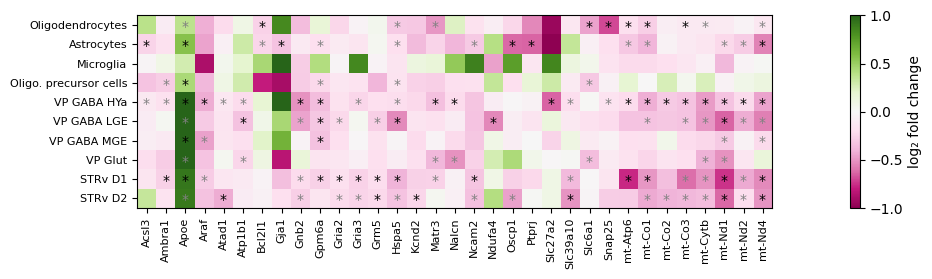

In [246]:
wgs = allpathwaygenes
wgsSel = np.isin(genes,wgs)
wglfc = logfcL[wgsSel,:]
wgpv = len(allpathwaygenes)*np.max(np.stack((pvalsL[wgsSel,:],pvals[wgsSel,:,2]),axis=2),axis=2) #different than both control groups
wgpva = len(genes)*np.max(np.stack((pvalsL[wgsSel,:],pvals[wgsSel,:,2]),axis=2),axis=2)
wgnames = genes[wgsSel]

#sorting
wgorder = np.argsort(np.mean(wglfc,axis=1),axis=0)
wgorder = np.argsort(np.argsort(allpathwaygenes,axis=0))
#wgorder = range(0,len(wgs))
wglfc = wglfc[wgorder]
wgsort = wgnames[wgorder]
wgpvsort = wgpv[wgorder]
wgpvasort = wgpva[wgorder]

plt.figure(figsize = (20,2.5))
plt.imshow(wglfc.transpose(),cmap='PiYG', vmin=-1, vmax=1)
plt.xticks(range(0,len(wgs)),labels=wgsort, rotation=90, size=8)
plt.yticks(range(0,len(clusters)),labels=clusters, size=8)
plt.colorbar(label='log\u2082 fold change')
for g in range(0,len(wgs)):
    for c in range(0,len(clusters)):
        if wgpvasort[g,c]<0.05:
            plt.text(x=g-0.2,y=c+0.3,s='*',size=10,color='k')
        else:
            if wgpvsort[g,c]<0.05:
                plt.text(x=g-0.2,y=c+0.3,s='*',size=10,color=(0.5,0.5,0.5))

plt.savefig(directory + '/Figures/KEGGDEGsAll.svg')

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


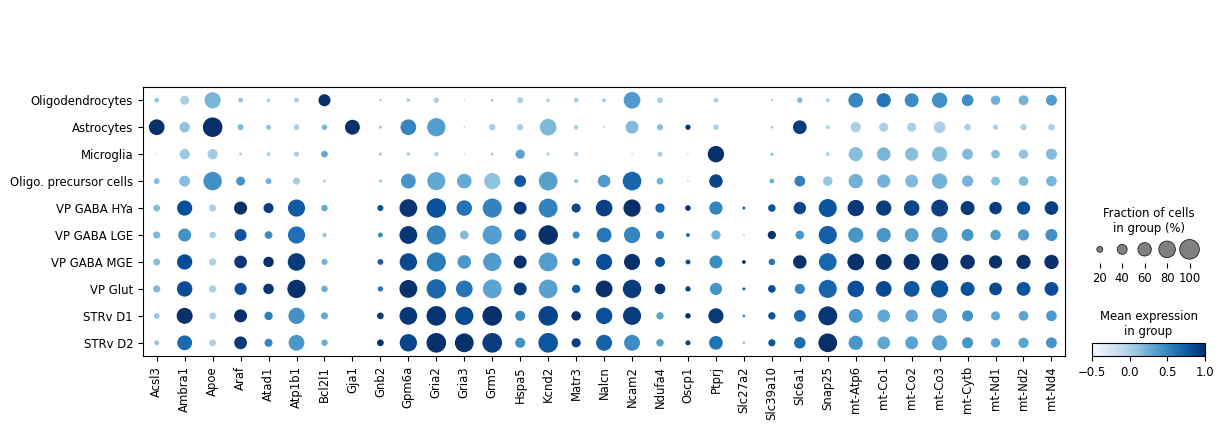

In [248]:
dp = sc.pl.dotplot(adata[adata.obs['RegionClass'].isin(clusters)], allpathwaygenes, layer='counts',groupby='RegionClass', categories_order=clusters,
                   standard_scale='var', vmin=-0.5, vmax=1,dendrogram=False, return_fig=True) 
dp.style(dot_edge_color=None, dot_edge_lw=0.5, cmap='Blues', x_padding=0.5, y_padding=0.5)

#dp.add_totals(sort=None, color='black').style(dot_edge_color=None, dot_edge_lw=0.5, cmap='Blues', x_padding=0.5, y_padding=0.5)
dp.savefig(directory + '/Figures/KEGGDEGsAllDot.svg')

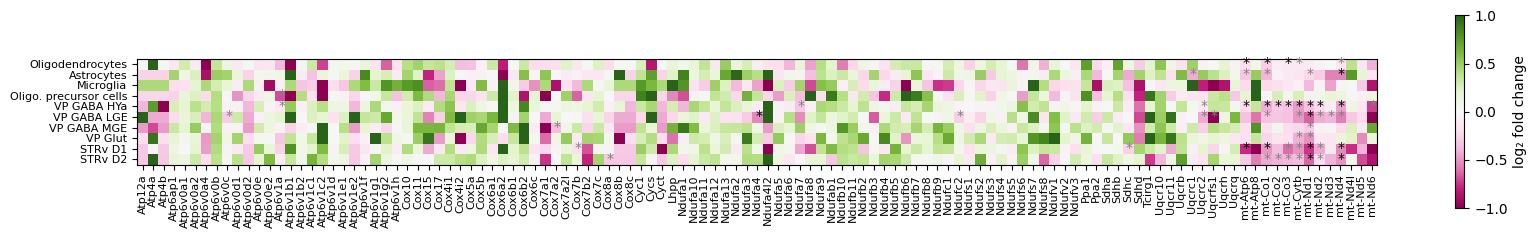

In [305]:
#look at a whole pathway
wgs = opgenes.name[opgenes.name.isin(genes)]
wgsSel = np.isin(genes,wgs)
wglfc = logfcL[wgsSel,:]
wgpv = len(wgs)*np.max(np.stack((pvalsL[wgsSel,:],pvals[wgsSel,:,2]),axis=2),axis=2) #different than both control groups
wgpva = len(genes)*np.max(np.stack((pvalsL[wgsSel,:],pvals[wgsSel,:,2]),axis=2),axis=2)
wgnames = genes[wgsSel]

#sorting
#wgorder = np.argsort(np.mean(wglfc,axis=1),axis=0)
#wgorder = np.argsort(np.argsort(wgs,axis=0))
wgorder = range(0,len(wgs))
wglfc = wglfc[wgorder]
wgsort = wgnames[wgorder]
wgpvsort = wgpv[wgorder]
wgpvasort = wgpva[wgorder]

plt.figure(figsize = (20,2.5))
plt.imshow(wglfc.transpose(),cmap='PiYG', vmin=-1, vmax=1)
plt.xticks(range(0,len(wgs)),labels=wgsort, rotation=90, size=8)
plt.yticks(range(0,len(clusters)),labels=clusters, size=8)
plt.colorbar(label='log\u2082 fold change')
for g in range(0,len(wgs)):
    for c in range(0,len(clusters)):
        if wgpvasort[g,c]<0.05:
            plt.text(x=g-0.2,y=c+0.3,s='*',size=10,color='k')
        else:
            if wgpvsort[g,c]<0.05:
                plt.text(x=g-0.2,y=c+0.3,s='*',size=10,color=(0.5,0.5,0.5))

#plt.savefig(directory + '/Figures/KEGGDEGsAll.svg')

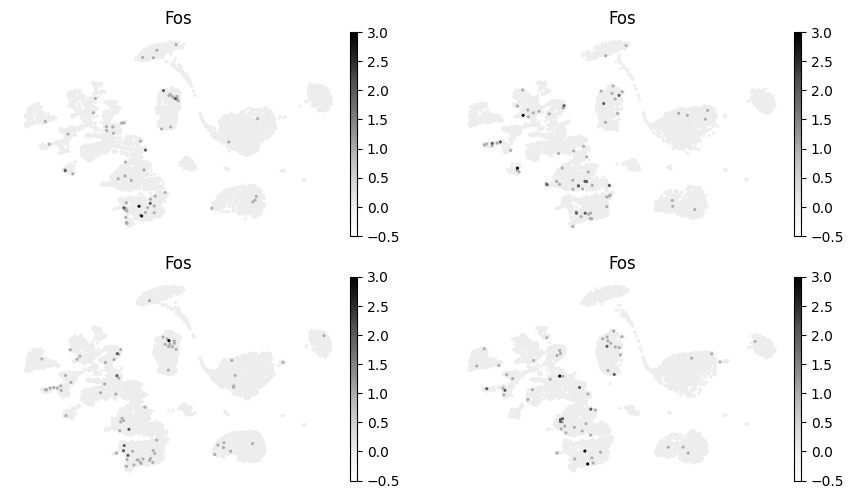

In [4]:
gtp='Fos'
plt.figure(figsize = (10.5,9))
um = plt.subplot(3,2,1)
um = sc.pl.umap(adata[adata.obs['Sample']=='CS'], color = [gtp], frameon = False,
                size=20, ax = um, layer = 'counts', vmin=-0.5, vmax=3,
                cmap='Grays',show=False)
um = plt.subplot(3,2,2)
um = sc.pl.umap(adata[adata.obs['Sample']=='CL'], color = [gtp], frameon = False,
                size=20, ax = um, layer = 'counts', vmin=-0.5, vmax=3,
                cmap='Grays',show=False)
um = plt.subplot(3,2,3)
um = sc.pl.umap(adata[adata.obs['Sample']=='HS'], color = [gtp], frameon = False,
                size=20, ax = um, layer = 'counts', vmin=-0.5, vmax=3,
                cmap='Grays',show=False)
um = plt.subplot(3,2,4)
um = sc.pl.umap(adata[adata.obs['Sample']=='HL'], color = [gtp], frameon = False,
                size=20, ax = um, layer = 'counts', vmin=-0.5, vmax=3,
                cmap='Grays',show=False)

In [210]:
logfcL[genes=='Fos']

array([[ 0.42329096,  0.62255432,  9.82016613, -8.70494528,  0.63887624,
        -0.25856342, -0.91502102,  8.71187597,  0.12755573, -0.41968815]])

In [209]:
pvalsL[genes=='Fos']

array([[0.72571191, 0.83020727, 0.24680061, 0.12404803, 0.76247486,
        0.48198224, 0.01811085, 0.10638251, 0.36821928, 0.0679193 ]])

In [268]:
gene2plot = 'Fos'
c = adata[:,adata.var.index==gene2plot].X
c = [x for y in c for x in y]
geneComp = pd.DataFrame({'counts':c,'condition':adata.obs['Sample'],'celltype':adata.obs['RegionClass'],'region':adata.obs['Region']})

In [270]:
geneComp

,counts,condition,celltype,region
HS:AAACCCAAGGAGCAAA-1,0.0,HS,STRv D1,STRv
HS:AAACCCAAGTGCAGGT-1,0.0,HS,Other,Other
HS:AAACCCACAAATCGGG-1,0.0,HS,VP GABA HYa,Both
HS:AAACCCACAGACATCT-1,0.0,HS,Astrocytes,Astrocytes
HS:AAACCCACAGCTCGGT-1,0.0,HS,VP GABA HYa,VP
...,...,...,...,...
CL:TTTGTTGAGCGACCCT-1,0.0,CL,Oligodendrocytes,Oligodendrocytes
CL:TTTGTTGAGTCACAGG-1,0.0,CL,VP GABA HYa,VP
CL:TTTGTTGCACAGCTTA-1,0.0,CL,Microglia,Microglia
CL:TTTGTTGCAGACCCGT-1,0.0,CL,STRv IC,STRv


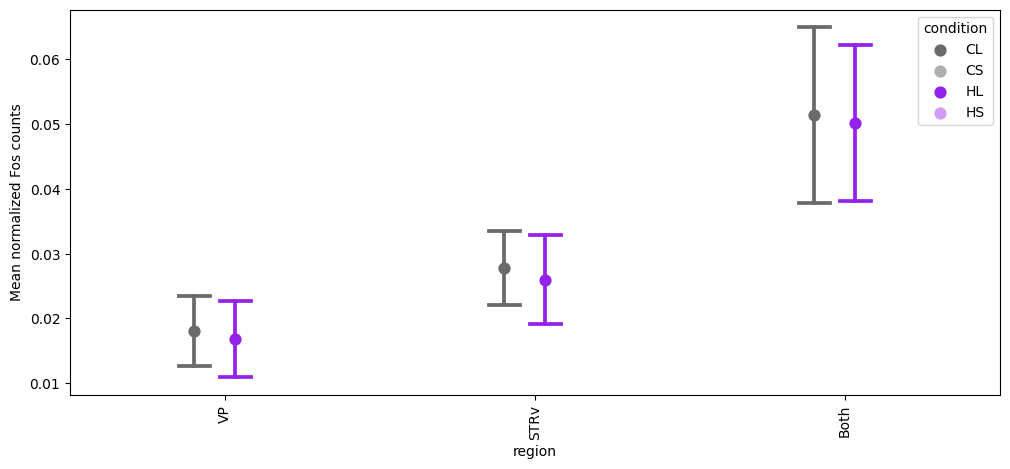

In [274]:
clusters = ['VP','STRv','Both']
geneCompSub = geneComp[(geneComp['condition'].isin(['CL','HL'])) & (geneComp['region'].isin(clusters))]
plt.figure(figsize = (12,5))
sns.pointplot(
    data=geneCompSub, x="region", y="counts",hue='condition', order=clusters,
    errorbar=("se"), linestyles=['None','None','None','None'], capsize=.1, dodge=0.2, palette=gpcolors)
plt.xticks(rotation=90)
plt.ylabel('Mean normalized Fos counts')
plt.savefig(directory + '/Figures/RNAFosRegion.svg')

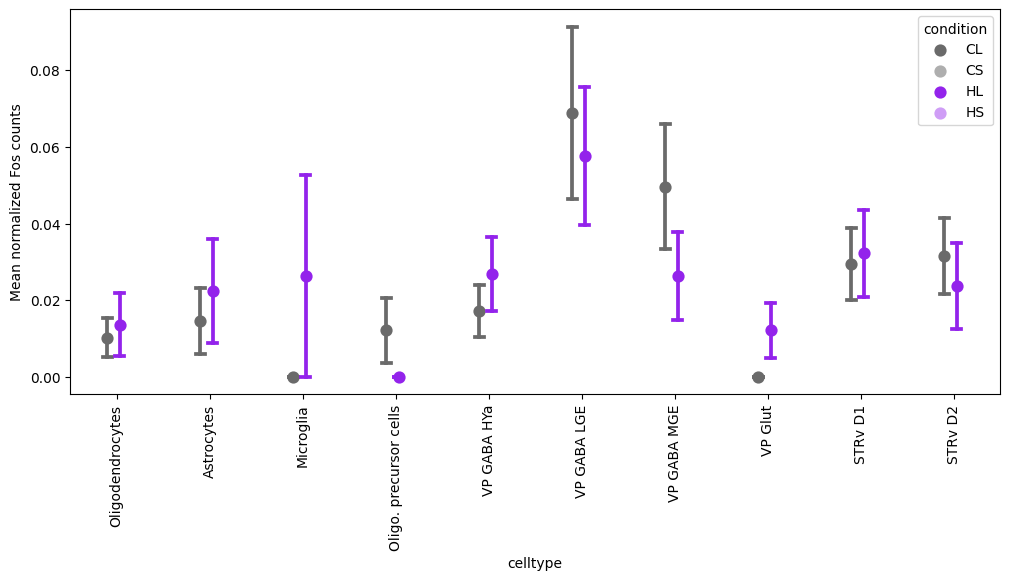

In [224]:
clusters = ['Oligodendrocytes','Astrocytes','Microglia','Oligo. precursor cells','VP GABA HYa','VP GABA LGE','VP GABA MGE','VP Glut','STRv D1','STRv D2']
geneCompSub = geneComp[(geneComp['condition'].isin(['CL','HL'])) & (geneComp['celltype'].isin(clusters))]
plt.figure(figsize = (12,5))
sns.pointplot(
    data=geneCompSub, x="celltype", y="counts",hue='condition', order=clusters,
    errorbar=("se"), linestyles=['None','None','None','None'], capsize=.1, dodge=0.2, palette=gpcolors)
plt.xticks(rotation=90)
plt.ylabel('Mean normalized Fos counts')
plt.savefig(directory + '/Figures/RNAFos.svg')

In [151]:
#markers of interest
strv = ['Rarb','Pde7b','Pdzd2']
vp = ['Dscam','Scn9a','Elavl4']
nt = ['Slc32a1','Slc17a6','Slc17a7','Slc17a8','Slc5a7']
msn = ['Drd1','Drd2','Drd3','Ppp1r1b']
opioid = ['Penk','Pdyn','Pomc','Oprm1','Oprk1','Oprd1']             
tf = ['Nfib','Tcf4','Etv1','Nkx2-1','Lhx6','Lhx8','Sox6','Gbx1','Npas1','Casz1','Prox1','Meis2',
      'Foxp2','Ebf1','Six3','Zfhx3','Zfhx4','Tcf7l2']#'Zbtb16', 'Pbx3'
marker = ['Moxd1','Sst','Npy','Tacr1','Gpc5','Elfn1','Cyp26b1','Penk','Chst9','Tshz1','Bnc2','Nts','Pdyn','Fign',
          'Trdn','Sema5a','Prlr','Tmem163','Calb2','Calb1','Drd3','Drd1','Drd2','Ppp1r1b']#,'Il1rapl2','Chrm3','Rai14']
hormones = ['Esr1','Esr2','Ar','Pgr','Crhr1','Crh','Crhr2','Nr3c1','Nr3c2','Ghrl','Mc4r','Mc5r','Lepr',
            'Sst','Sstr1','Sstr2','Sstr3','Sstr4',
            'Npy','Npy1r','Npy5r','Nts','Ntsr1','Hcrt','Hcrtr1','Hcrtr2','Prlr']
gaba = ['Slc32a1','Gad1','Gad2','Gabra1','Gabra2','Gabra3','Gabra4','Gabra5','Gabrb1','Gabrb2','Gabrb3',
        'Gabrg1','Gabrg2','Gabrg3','Gabrd','Gabrq','Gabrr1','Gabrr2','Gabrr3','Gabbr1','Gabbr2']
glutamate = ['Slc17a6','Slc17a7','Slc17a8','Gria1','Gria2','Gria4',
             'Grid1','Grid2','Grik1','Grik2','Grik3','Grik4','Grik5',
             'Grin1','Grin2a','Grin2b','Grin2c','Grin2d','Grin3a','Grin3b',
            'Grm1','Grm2','Grm3','Grm4','Grm5','Grm7','Grm8']
dopamine = ['Th','Drd1','Drd2','Drd3'] #Slc18a1
serotonin = ['Slc6a4','Htr1a','Htr1b','Htr1d','Htr1f','Htr2a','Htr2b','Htr2c','Htr3a',
             'Htr4','Htr5a','Htr5b','Htr6','Htr7']
ach = ['Slc5a7','Prima1','Chrna1','Chrna2','Chrna3','Chrna4','Chrna5','Chrna7','Chrna10',
       'Chrnb1','Chrnb2','Chrnb3','Chrnb4',
      'Chrm1','Chrm2','Chrm3','Chrm4','Chrm5']
glycine = ['Slc6a9','Glra1','Glra2','Glra3','Glra4','Glrb']
norep = ['Slc6a2','Adra1b','Adra1d','Adra2a','Adra2b','Adra2c','Adrb1']

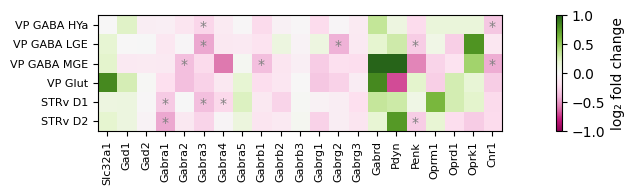

In [259]:
testList = ['Slc32a1','Gad1','Gad2','Gabra1','Gabra2','Gabra3','Gabra4','Gabra5','Gabrb1','Gabrb2','Gabrb3',
        'Gabrg1','Gabrg2','Gabrg3','Gabrd','Pdyn','Penk','Oprm1','Oprd1','Oprk1','Cnr1']
#'Slc17a6','Slc17a8','Gria1','Gria2','Gria3','Gria4',
#             'Grid1','Grid2','Grik1','Grik2','Grik3','Grik4','Grik5',
#             'Grin1','Grin2a','Grin2b','Grin2c','Grin2d','Grin3a','Grin3b',
#            'Grm1','Grm2','Grm3','Grm4','Grm5','Grm7','Grm8',
#,'Gabrr1','Gabrr2','Gabrr3'
#,'Slc6a1','Slc6a11','Slc6a12','Slc6a13'
wgs = np.array(testList)
wgsSel = np.isin(genes,wgs)
wglfc = logfcL[wgsSel,4:]
wgpv = len(testList)*np.max(np.stack((pvalsL[wgsSel,4:],pvals[wgsSel,4:,2]),axis=2),axis=2) #different than both control groups
wgpva = len(genes)*np.max(np.stack((pvalsL[wgsSel,4:],pvals[wgsSel,4:,2]),axis=2),axis=2)
wgnames = genes[wgsSel]

#sorting
wgorder = np.argsort(np.mean(wglfc,axis=1),axis=0)
wgorder = np.argsort(np.argsort(testList,axis=0))
#wgorder = range(0,len(wgs))
wglfc = wglfc[wgorder]
wgsort = wgnames[wgorder]
wgpvsort = wgpv[wgorder]
wgpvasort = wgpva[wgorder]

plt.figure(figsize = (14,1.5))
plt.imshow(wglfc.transpose(),cmap='PiYG', vmin=-1, vmax=1)
plt.xticks(range(0,len(wgs)),labels=wgsort, rotation=90, size=8)
plt.yticks(range(0,len(clusters)-4),labels=clusters[4:], size=8)
plt.colorbar(label='log\u2082 fold change')
for g in range(0,len(wgs)):
    for c in range(0,len(clusters)-4):
        if wgpvasort[g,c]<0.05:
            plt.text(x=g-0.2,y=c+0.3,s='*',size=10,color='k')
        else:
            if wgpvsort[g,c]<0.05:
                plt.text(x=g-0.2,y=c+0.3,s='*',size=10,color=(0.5,0.5,0.5))

plt.savefig(directory + '/Figures/GABADEGsAll.svg')

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


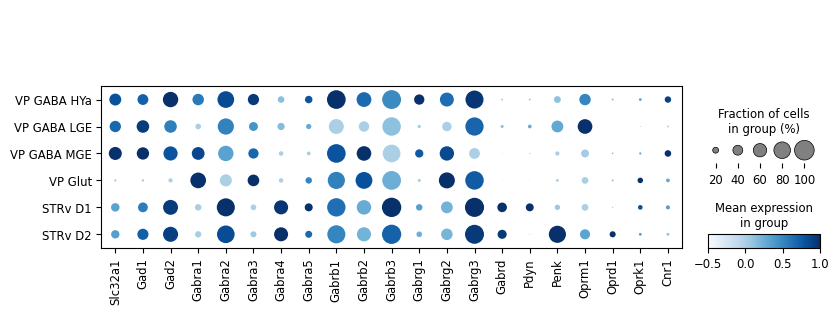

In [260]:
dp = sc.pl.dotplot(adata[adata.obs['RegionClass'].isin(clusters[4:])], testList, layer='counts',groupby='RegionClass', categories_order=clusters[4:],
                   standard_scale='var', vmin=-0.5, vmax=1,dendrogram=False, return_fig=True) 
dp.style(dot_edge_color=None, dot_edge_lw=0.5, cmap='Blues', x_padding=0.5, y_padding=0.5)

#dp.add_totals(sort=None, color='black').style(dot_edge_color=None, dot_edge_lw=0.5, cmap='Blues', x_padding=0.5, y_padding=0.5)
dp.savefig(directory + '/Figures/GABADEGsAllDot.svg')